# Prototype analysis

Notebook to extract prototypes from each class. 3 types of prototypes are considered:
- Top class prototypes: trajectories that represent at best a class according to the CNN. These are extracted by selecting trajectories
 for which the model prediction are correct and with the highest classification confidence for the given class.
- Worst class prototypes: trajectories that were mistaken for another class, with largest confidence. These are extracted
 by selecting trajectories for which the model prediction is wrong while having the highest confidence in classification for the given class.
- Least correlated prototypes: trajectories that represent the diversity in a class. These are extracted by selecting
trajectories where the model confidence wsa highest than a minimal threshold while being correct. In addition, the set
of trajectories is grown with a greedy algorithm that selects sequentially trajectories. The algorithm selects the next 
trajectory whose representation in the output layer (right before classification) is as least correlated to the rest of 
the set as possible.

## Import libraries

In [1]:
# Standard libraries
import torch
import sys
from torch.utils.data import DataLoader
from torchvision import transforms
import seaborn as sns
import matplotlib as plt
import pandas as pd
import os
import numpy as np
import plotly.express as px

# Custom functions/classes
path_to_module = '..'  # Path where all the .py files are, relative to the notebook folder
sys.path.append(path_to_module)
import results_model
from class_dataset import myDataset, RandomCrop, Subtract, ToTensor
from utils import model_output
from load_data import DataProcesser

# For reproducibility
myseed = 7
torch.manual_seed(myseed)
torch.cuda.manual_seed(myseed)
np.random.seed(myseed)

## Import data, model and choose from which set to look for prototypes

Choose whether prototypes should be looked for in the training, validation, test set or in all of them together.

In [2]:
prototypes_set = 'all'
assert prototypes_set in ['train', 'validation', 'test', 'all']

In [3]:
data_file = 'C:/Users/pixel/Dropbox/Work/TSclass_GF/data/SynUni.zip'
model_file = 'C:/Users/pixel/Dropbox/CNN_paper_MarcAntoine/forPaper/models/FRST_classAB/2020-07-17-18__12__13_SynUni.pytorch'

batch_size = 400 # Set as high as your memory allows to speed up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
meas_var = None  # Set to None for auto detection
start_time = None  # Set to None for auto detection
end_time = None  # Set to None for auto detection

model = torch.load(model_file)
model.eval()
model.double()
model.batch_size = 1  # Set it to 1!
model = model.to(device)

# Select measurements and times, subset classes and split the dataset
data = DataProcesser(data_file)
meas_var = data.detect_groups_times()['groups'] if meas_var is None else meas_var
start_time = data.detect_groups_times()['times'][0] if start_time is None else start_time
end_time = data.detect_groups_times()['times'][1] if end_time is None else end_time
data.subset(sel_groups=meas_var, start_time=start_time, end_time=end_time)
data.get_stats()
data.split_sets()
classes = tuple(data.classes.iloc[:,1])
dict_classes = data.classes[data.col_classname]

# Input preprocessing, this is done sequentially, on the fly when the input is passed to the network
subtract_numbers = [data.stats['mu'][meas]['train'] for meas in meas_var]
ls_transforms = transforms.Compose([
    Subtract(subtract_numbers),
    RandomCrop(output_size=model.length, ignore_na_tails=True),
    ToTensor()])

# Set the DataLoader with the selected set
if prototypes_set == 'train':
    data_toLoader = myDataset(dataset=data.train_set, transform=ls_transforms)
elif prototypes_set == 'validation':
    data_toLoader = myDataset(dataset=data.validation_set, transform=ls_transforms)
elif prototypes_set == 'test':
    data_toLoader = myDataset(dataset=data.test_set, transform=ls_transforms)
elif prototypes_set == 'all':
    data_toLoader = myDataset(dataset=data.dataset, transform=ls_transforms)

myDataLoader = DataLoader(dataset=data_toLoader,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=False)

..\load_data.py:473: UserWarning:

Data were not processed.



Plot some trajectories to check that the data loading and processing is properly done.

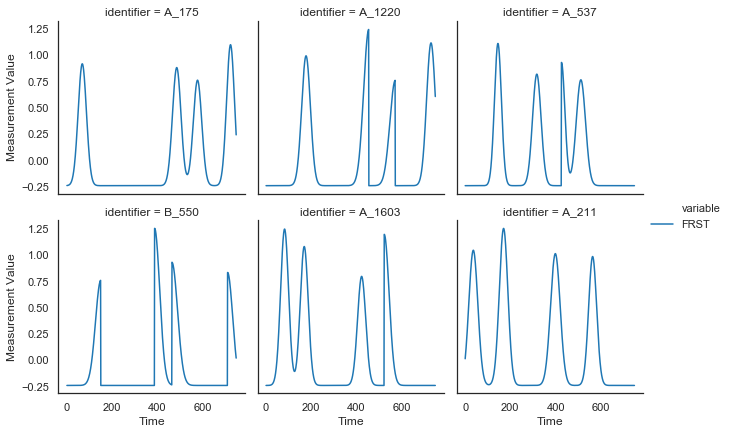

In [4]:
n_smpl = 6
indx_smpl = np.random.randint(0, len(data_toLoader), n_smpl)
length = model.length

col_ids = []
col_lab = []
col_mes = []
# Long format for seaborn grid, for loop to avoid multiple indexing
# This would triggers preprocessing multiple times and add randomness with some preprocessing steps
for i in indx_smpl:
    smpl = data_toLoader[i]
    col_ids.append(smpl['identifier'])
    col_lab.append(smpl['label'].item())
    col_mes.append(smpl['series'].numpy().transpose())
col_ids = pd.Series(np.hstack(np.repeat(col_ids, length)))
col_lab = pd.Series(np.hstack(np.repeat(col_lab, length)))
col_mes = pd.DataFrame(np.vstack(col_mes), columns=meas_var)
col_tim = pd.Series(np.tile(np.arange(0, length), n_smpl))

df_smpl = pd.concat([col_ids, col_lab, col_tim, col_mes], axis=1)
df_smpl.rename(columns={0: 'identifier', 1: 'label', 2:'time'}, inplace=True)
df_smpl = df_smpl.melt(id_vars=['identifier', 'label', 'time'], value_vars=meas_var)

sns.set_style('white')
sns.set_context('notebook')
grid = sns.FacetGrid(data=df_smpl, col='identifier', col_wrap=3, sharex=True)
grid.map_dataframe(sns.lineplot, x='time', y='value', hue='variable', ci=None)
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

## Confusion matrix

Confusion matrix along with the precision for each class. Variations between runs can be observed if the input is augmented with random cropping.

In [5]:
accuracy = results_model.acc_per_class(model, myDataLoader, device, dict_classes)
conft = results_model.confusion_matrix(model, myDataLoader, device, dict_classes)
conft['Precision'] = accuracy
print(conft)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]
..\results_model.py:57: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]

Prediction     A     B  Precision
Class                            
A           1689   311     0.8445
B            343  1657     0.8285


## Prototypes extraction

In [6]:
# Number of prototypes from each category
ntop = 10
nworst = 10
nuncor = 10
nrandom = 10

# Minimal confidence for uncorrelated prototypes
threshold_confidence = 0.9  

# Path where to export plots and table with prototypes
out_dir = 'output/' + '_'.join(meas_var)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# Plot and export options
plot_results = True
plot_results_interactive = False
export_plot_results = True
export_table_prototypes = True

In [7]:
col_id = data.col_id
col_class = data.col_class
col_classname = data.col_classname

def make_subset_forPlot(sel_ids, sel_id_vars = [col_id, col_class]):
    subset = data.dataset.loc[data.dataset[col_id].isin(sel_ids)]
    subset = subset.melt(id_vars=sel_id_vars)
    subset[['Meas','Time']]=subset['variable'].str.extract(r'^(?P<Meas>[A-Za-z0-9]+)_(?P<Time>\d+)$')
    subset['Time'] = subset['Time'].astype('int')
    subset.sort_values('Time', inplace = True)
    subset = pd.merge(subset, data.classes, left_on=col_class, right_on=col_class)
    return(subset)

def make_grid_plot(in_data, ncol_plot, out_file=None):
    sns.set_style('ticks')
    sns.set_context('paper')
    grid = sns.FacetGrid(data=in_data, col=col_id, col_wrap=ntop, sharex=True, sharey=False, aspect=2)
    grid.map_dataframe(sns.lineplot, x="Time", y="value", hue="Meas", ci=None)
    grid.set(xlabel='Time', ylabel='Measurement')
    grid.add_legend()
    if out_file:
        grid.savefig(out_file)

### Top trajectories per class

In [8]:
tops = results_model.top_confidence_perclass(model, myDataLoader, n=ntop, labels_classes=dict_classes)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


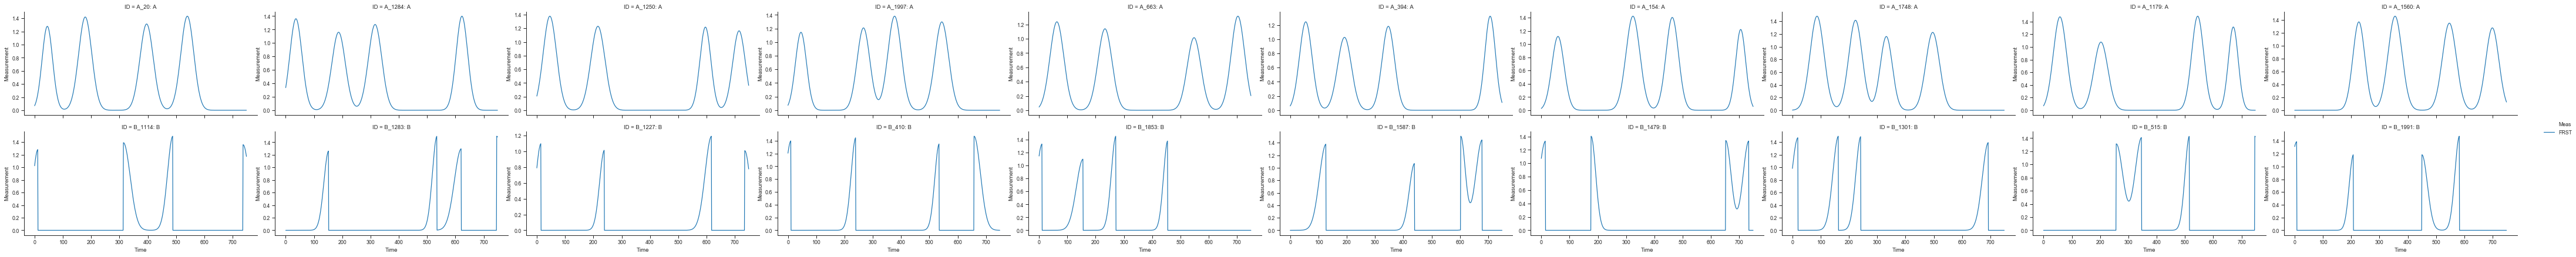

In [9]:
if plot_results:
    subset = make_subset_forPlot(tops[col_id])
    subset[col_id] = subset[col_id] + ': ' + subset[col_classname]
    subset.sort_values(by=[col_classname], inplace=True)
    out_file = 'output/' + '_'.join(meas_var) + '/tops_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf' if export_plot_results else None
    make_grid_plot(subset, ntop, out_file=out_file)

Interactive plot:

In [10]:
if plot_results_interactive:
    selected_class = pd.unique(subset['class'])
    # selected_class=['EGF']
    px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='Meas',
            line_group='Meas', facet_col='ID', width=2500, height=400)

### Least correlated set per class

When choosing uncorrelated curves, pick only from curves for which the model confidence in the input class is at least "threshold_confidence".

In [11]:
uncorr = results_model.least_correlated_set(model, myDataLoader, n=nuncor, labels_classes=dict_classes, threshold_confidence=threshold_confidence)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.81it/s]


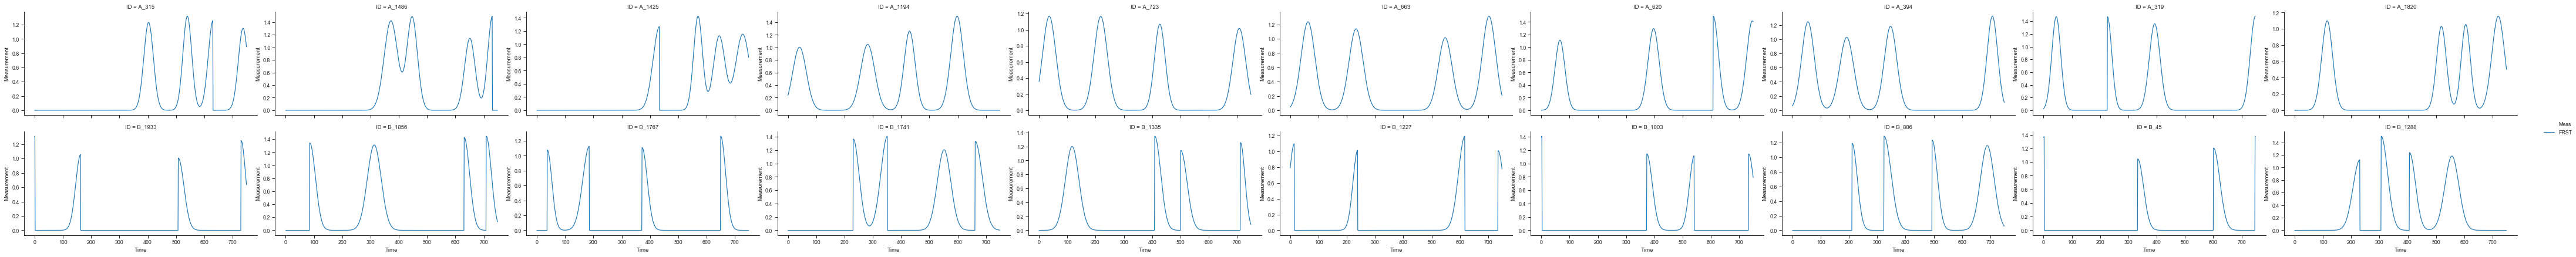

In [12]:
if plot_results:
    subset = make_subset_forPlot(uncorr[col_id])
    out_file = 'output/' + '_'.join(meas_var) + '/uncorr_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf'  if export_plot_results else None
    make_grid_plot(subset, nuncor, out_file=out_file)

Interactive plot:

In [13]:
if plot_results_interactive:
    selected_class=pd.unique(subset['class'])
    # selected_class=['EGF']
    px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='Meas',
            line_group='Meas', facet_col='ID', width=2500, height=400)

### Worst trajectory per class

In [14]:
worsts = results_model.worst_classification_perclass(model, myDataLoader, n=nworst, labels_classes=dict_classes)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


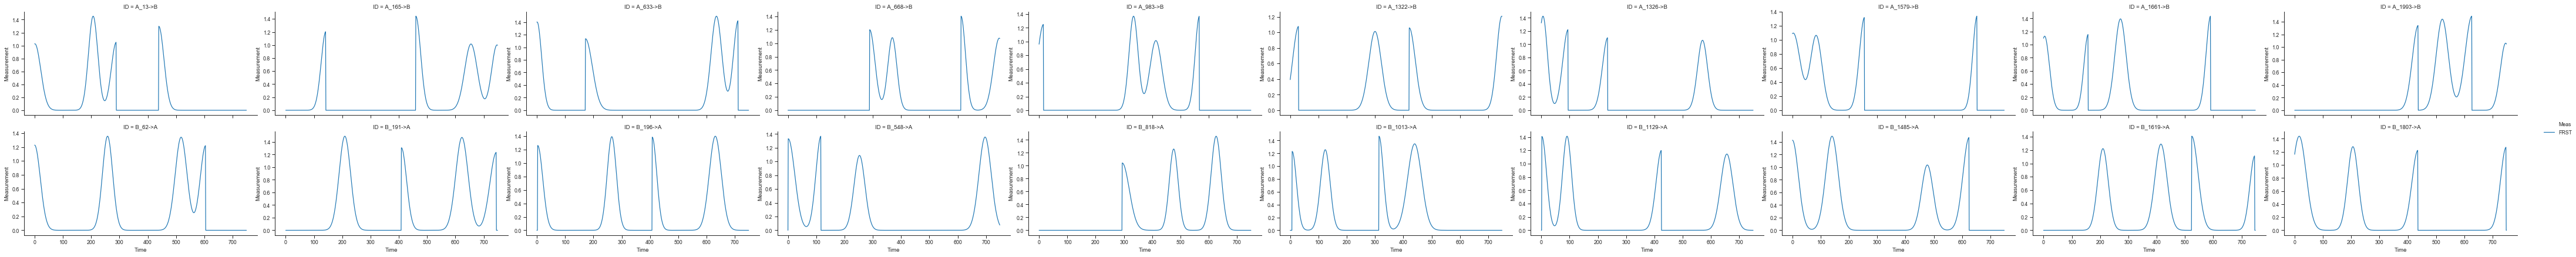

In [15]:
if plot_results:
    subset = data.dataset.loc[data.dataset['ID'].isin(worsts['ID'])]
    subset = pd.merge(subset, worsts[['ID', 'Prediction']], on='ID')
    subset = subset.melt(id_vars=['ID', 'class', 'Prediction'])
    subset[['Meas','Time']]=subset['variable'].str.extract(r'^(?P<Meas>[A-Za-z]+)_(?P<Time>\d+)$')
    subset['Time'] = subset['Time'].astype('int')
    subset = pd.merge(subset, data.classes, left_on=col_class, right_on=col_class)
    subset['ID'] = subset['ID'] + '->' + subset['Prediction']

    out_file = 'output/' + '_'.join(meas_var) + '/worsts_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf' if export_plot_results else None
    make_grid_plot(subset, nworst, out_file=out_file)

Interactive plot:

In [16]:
if plot_results_interactive:
    selected_class=pd.unique(subset['class'])
    # selected_class=['EGF']
    px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='Meas',
            line_group='Meas', facet_col='ID', width=2500, height=400)

### Random sample

Get a random sample of trajectories.

In [17]:
randoms_ids = []
for classe in data.validation_set['class'].unique():
    randoms_ids += list(data.dataset.loc[data.dataset['class']==classe]['ID'].sample(nrandom))
randoms = model_output(model, myDataLoader)
randoms = randoms.loc[randoms['ID'].isin(randoms_ids)]

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]


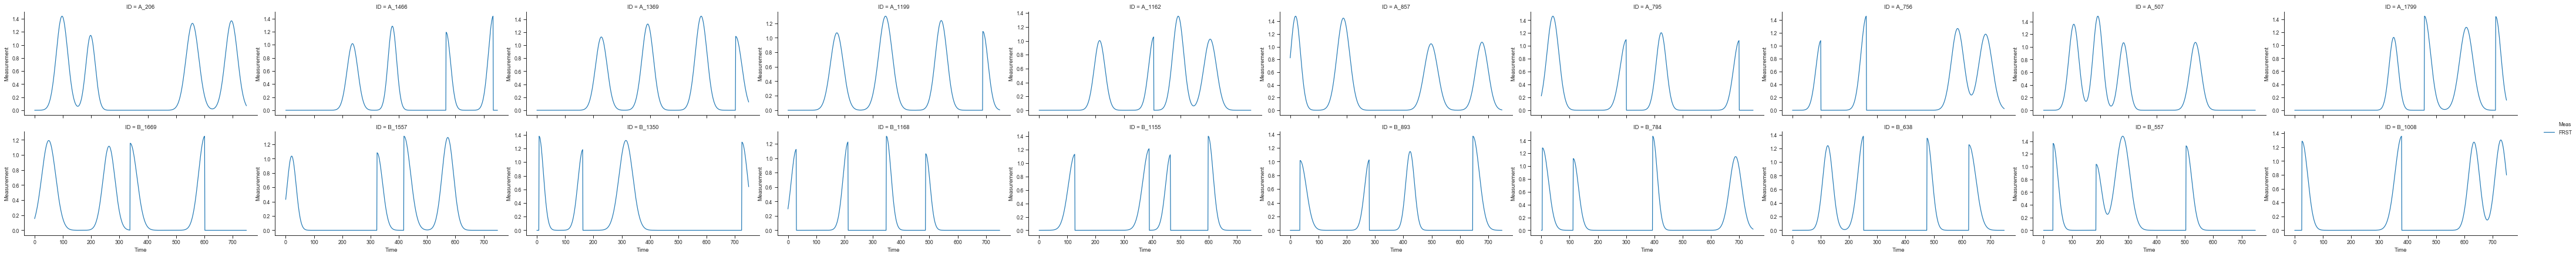

In [18]:
if plot_results:
    subset = make_subset_forPlot(randoms[col_id])
    out_file = 'output/' + '_'.join(meas_var) + '/random_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf' if export_plot_results else None
    make_grid_plot(subset, nworst, out_file=out_file)

### Table with all prototypes

In [19]:
tops['Category'] = 'Top'
worsts['Category'] = 'Worst'
uncorr['Category'] = 'Uncorr_' + str(threshold_confidence * 100)
randoms['Category'] = 'Random'
proto_table = pd.concat([tops, worsts, uncorr, randoms])

In [20]:
if export_table_prototypes:
    out_file = out_dir + '/protoTable_' + os.path.basename(model_file).rstrip('.pytorch') + '.csv'
    proto_table.to_csv(out_file, index=False)